# Library Imports

In [1]:
# Import DeepSurv
import sys
sys.path.append('../deepsurv')
import deep_surv

from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import PyTorch for our models
import torch

In [3]:
# check torch GPU usage

if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))


True
0
1
Quadro RTX 5000


# Load Data

In [4]:
base_dataf = "/gpfs/ysm/project/morgan_levine/ym362/smita_dl/"

In [5]:
phenos = pd.read_feather(base_dataf + "phenoFHS.feather" )
dna = pd.read_feather(base_dataf + "FHS_DNAm.feather" )

In [6]:
subset_idxs = (phenos['Lab'] == 2) & (phenos['Cohort'] == "Offspring") 

In [7]:
phenos = phenos[subset_idxs]
dna = dna[subset_idxs]

## Write Train/Test Subset to File

In [8]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
# test = sss.split(phenos.loc[subset_idxs], phenos.loc[subset_idxs,"Dead"])
# train_idxs, test_idxs = next(test)

In [9]:
# phenos.loc[train_idxs].reset_index().to_feather(base_dataf + "phenoFHS_lab2offspring_train.feather")
# phenos.loc[test_idxs].reset_index().to_feather(base_dataf + "phenoFHS_lab2offspring_test.feather")
# dna.loc[train_idxs].reset_index().to_feather(base_dataf + "FHS_DNAm_lab2offspring_train.feather")
# dna.loc[test_idxs].reset_index().to_feather(base_dataf + "FHS_DNAm_lab2offspring_test.feather")

In [10]:
phenos["Dead"].value_counts()

0.0    1800
1.0     209
Name: Dead, dtype: int64

In [11]:
dna.shape

(2009, 443206)

# Cox Regression Model

In order to perform a Cox Regression of our data, we need to compute the PCA, since we aren't able to use the full dataframe

In [13]:
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA


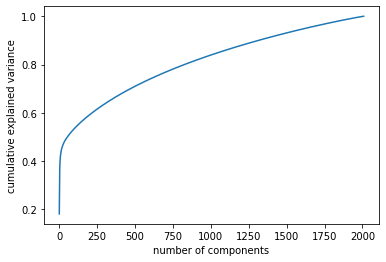

In [14]:
pca = PCA().fit(dna)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [11]:
# run PCA on methylation data since we can't actually run Cox Regression on the whole input
pca = PCA(n_components=500)
dna_transformed = pca.fit_transform(dna)


In [12]:
np.sum(pca.explained_variance_ratio_)

0.7042420413795097

In [13]:
# convert back into a dataframe
dna_transformed = pd.DataFrame(dna_transformed, columns=[f'pca_{x}' for x in range(dna_transformed.shape[1])])

# set the index to the original indices
dna_transformed = dna_transformed.set_index(dna.index)

In [14]:
# prepare data with an event column and a duration column
cox_input = dna_transformed.join(phenos[['Dead',"Time"]])

In [15]:
cox_input

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_492,pca_493,pca_494,pca_495,pca_496,pca_497,pca_498,pca_499,Dead,Time
1,13.716787,-1.558586,-3.220982,-2.286837,2.417527,2.154161,-2.052442,-0.746296,-0.360672,0.327052,...,0.028168,0.565570,-0.882593,-0.344522,0.298614,0.162359,-0.285850,0.120309,0.0,14420
3,-7.309120,-15.512144,-7.259762,-4.229186,0.062292,1.386955,4.706604,0.221895,2.382857,-1.327048,...,0.229346,0.227232,0.049360,-0.107122,0.031898,-0.268971,-0.399861,0.088944,0.0,15724
4,-8.255475,-9.602253,2.543081,-4.733151,0.518922,2.697289,-1.084806,0.243394,-1.425438,9.969854,...,-1.672097,0.972277,-0.981270,-0.365607,0.728121,0.437011,-0.796642,0.477297,0.0,15689
5,-11.085015,3.276686,-3.768612,-7.094097,9.061218,0.555473,-2.715170,0.240786,0.367649,-0.155130,...,0.956008,-0.575603,-0.396693,-0.053335,-0.645554,0.328621,-1.024438,0.686373,0.0,15341
6,-9.017412,9.672317,0.789139,1.978352,4.327984,-1.975158,-1.146814,-3.507961,-1.217412,-1.556741,...,-0.001011,-0.132469,0.537570,-0.162533,0.384906,-0.047407,0.176584,0.443777,0.0,14610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,13.737763,-1.190169,7.287787,-1.191373,-1.544345,-2.518621,1.125048,-0.086807,-2.602440,-0.255865,...,-0.124089,0.316191,-0.055978,-0.266160,-0.323430,0.265556,-0.553046,0.148936,1.0,14213
2473,13.519987,1.050288,-3.340112,0.038026,-1.363563,5.118804,-0.421466,-0.296798,1.542489,4.958323,...,-0.210604,0.124728,0.162313,0.088918,0.278605,-0.342865,0.291301,0.042836,0.0,15607
2474,-8.472000,-9.429330,4.876037,-4.129484,-0.607790,2.585021,0.426774,-0.110057,-0.043669,8.973379,...,0.068514,0.128058,0.006193,0.299514,-0.038321,0.122445,0.342902,-0.027290,0.0,14527
2476,-10.229832,-0.012168,0.812161,1.385769,3.303200,1.039097,-1.319358,-0.690464,2.484640,-1.617148,...,0.056217,0.312125,0.236706,0.271934,-0.218691,-0.112848,0.063595,-0.284723,0.0,15716


In [16]:
cph = CoxPHFitter(penalizer=0.1)

In [17]:
cph.fit(cox_input, duration_col='Time', event_col='Dead', batch_mode=True, step_size=0.3, show_progress=True)

Iteration 1: norm_delta = 1.32543, step_size = 0.3000, log_lik = -1533.77078, newton_decrement = 282.26618, seconds_since_start = 0.8
Iteration 2: norm_delta = 0.67269, step_size = 0.3000, log_lik = -1392.78698, newton_decrement = 90.32729, seconds_since_start = 1.5
Iteration 3: norm_delta = 0.42859, step_size = 0.3000, log_lik = -1347.01334, newton_decrement = 38.83684, seconds_since_start = 2.2
Iteration 4: norm_delta = 0.25591, step_size = 0.3900, log_lik = -1322.70872, newton_decrement = 13.72255, seconds_since_start = 3.0
Iteration 5: norm_delta = 0.12815, step_size = 0.5070, log_lik = -1312.32583, newton_decrement = 3.33593, seconds_since_start = 3.7
Iteration 6: norm_delta = 0.04493, step_size = 0.6591, log_lik = -1309.37377, newton_decrement = 0.39811, seconds_since_start = 4.4
Iteration 7: norm_delta = 0.00665, step_size = 0.8568, log_lik = -1308.98323, newton_decrement = 0.00853, seconds_since_start = 5.1
Iteration 8: norm_delta = 0.00001, step_size = 1.0000, log_lik = -1308.

<lifelines.CoxPHFitter: fitted with 2009 total observations, 1800 right-censored observations>

In [64]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2009 total observations, 1800 right-censored observations>
             duration col = 'Time'
                event col = 'Dead'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2009
number of events observed = 209
   partial log-likelihood = -1308.97
         time fit was run = 2021-05-19 14:33:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
pca_0       0.01       1.01       0.00            -0.00             0.02                 1.00                 1.02
pca_1      -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
pca_2       0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
pca_3      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
pca_4       0.08       1.08       0.01             0.05             0.11                 1.05                 1.11
pca_5      -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
pca_6       0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
pca_7      -0.04       0.96       0.03            -0.09             0.01                 0.92                 1.01
pca_8      -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
pca_9       0.03       1.03       0.03            -0.02             0.09                 0.98                 1.09
pca_10      0.08       1.09       0.03             0.02             0.14                 1.03                 1.15
pca_11      0.08       1.08       0.03             0.02             0.14                 1.02                 1.15
pca_12      0.06       1.06       0.03            -0.01             0.13                 0.99                 1.13
pca_13      0.02       1.02       0.03            -0.05             0.08                 0.95                 1.09
pca_14     -0.08       0.92       0.04            -0.15            -0.01                 0.86                 0.99
pca_15     -0.07       0.93       0.04            -0.15             0.00                 0.86                 1.00
pca_16      0.05       1.05       0.04            -0.03             0.13                 0.97                 1.13
pca_17     -0.02       0.98       0.05            -0.11             0.07                 0.89                 1.07
pca_18      0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
pca_19      0.03       1.03       0.05            -0.07             0.13                 0.94                 1.13
pca_20      0.03       1.03       0.05            -0.06             0.13                 0.94                 1.13
pca_21      0.02       1.02       0.05            -0.08             0.11                 0.93                 1.12
pca_22      0.08       1.08       0.05            -0.01             0.18                 0.99                 1.19
pca_23     -0.00       1.00       0.05            -0.10             0.09                 0.90                 1.10
pca_24     -0.09       0.92       0.05            -0.19             0.02                 0.83                 1.02
pca_25      0.04       1.04       0.05            -0.07             0.14                 0.93                 1.15
pca_26      0.10       1.11       0.05            -0.00             0.20                 1.00                 1.23
pca_27     -0.10       0.91       0.05            -0.20             0.01                 0.82                 1.01
pca_28     -0.06       0.94       0.05            -0.16             0.05                 0.85                 1.05
pca_29     

,1,3,4,5,6,7,8,10,12,13
15000.0,0.897172,0.983924,0.942559,0.983788,0.87538,0.954967,0.881807,0.834188,0.919388,0.812667


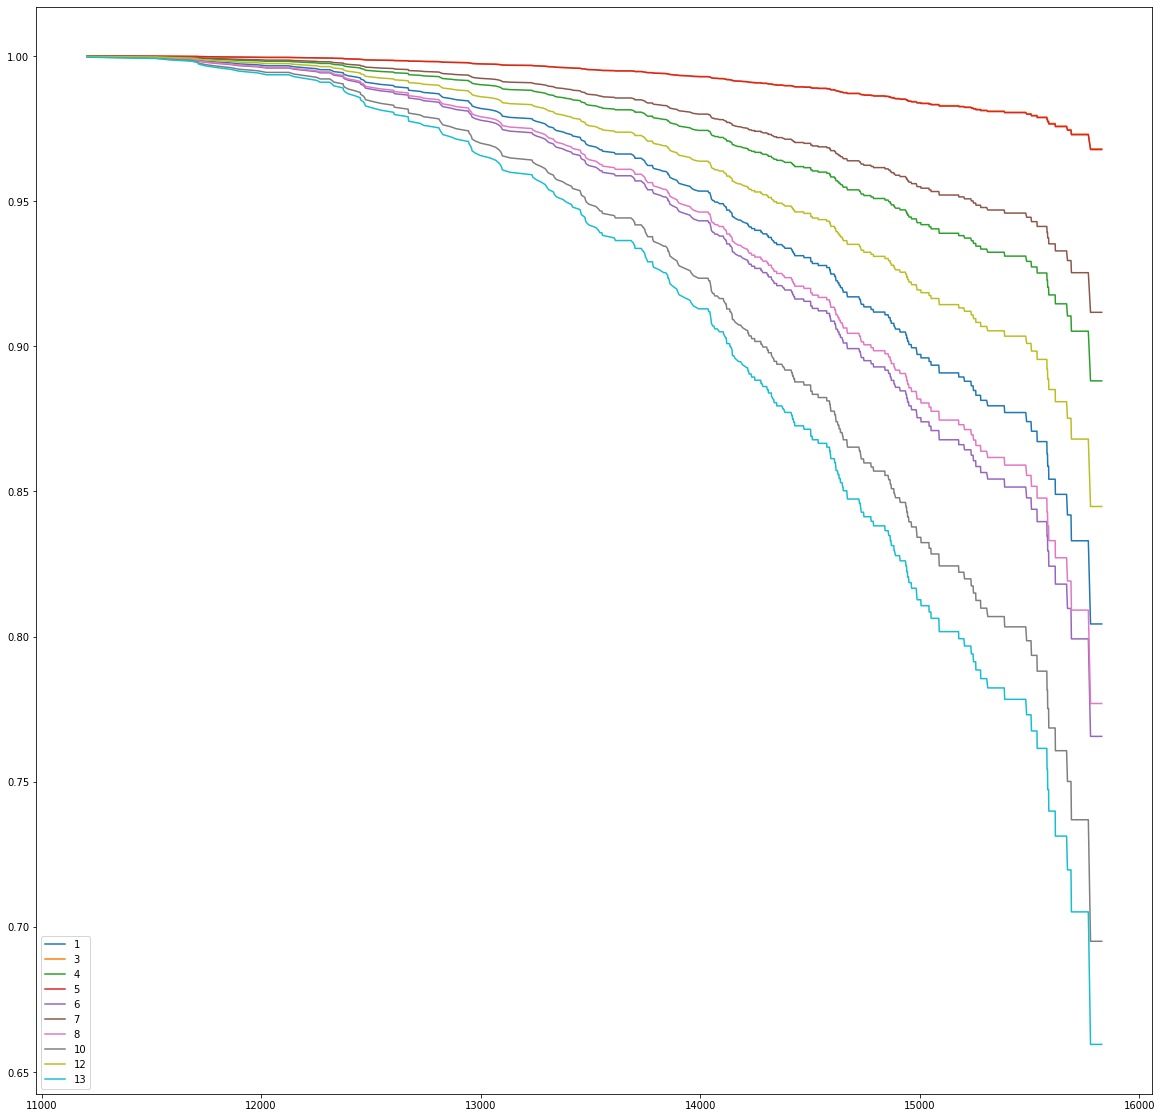

In [18]:
# First train some fitters and plot them
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# These calls below are equivalent
# add_at_risk_counts(cph)
# cph.plot_survival_function(cox_input)
cph.predict_survival_function(cox_input[cox_input["Dead"] == 0].iloc[:10]).rename(columns={0:'CoxPHFitter'}).plot(ax=ax)
# cph.predict_survival_function(cox_input[cox_input["Dead"] == 0].iloc[:10], times=[15000])

<AxesSubplot:xlabel='log(HR) (95% CI)'>

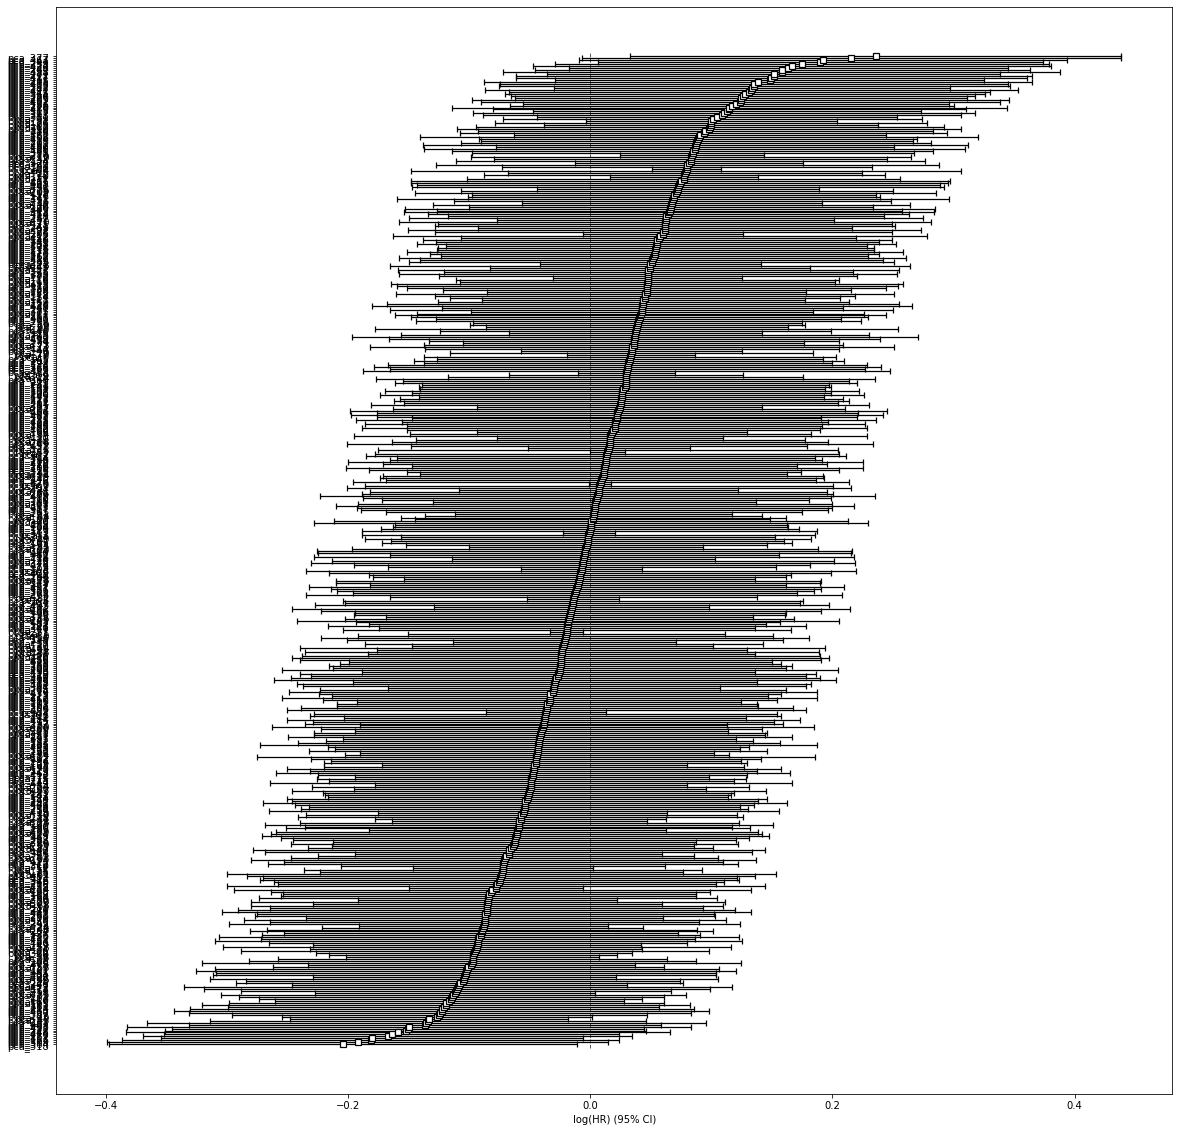

In [19]:
# cph.print_summary()  # access the individual results using cph.summary
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# print(np.exp(max(cph.params_)))
plt.figure(figsize=(20,20))
cph.plot()

# DeepSurv Model Run on Epigenetic Data

In [25]:
# break up into train and test data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
idxs = sss.split(phenos, phenos["Dead"])
train_idxs, test_idxs = next(idxs)

In [27]:
train_pcs = cox_input.iloc[train_idxs]
test_pcs = cox_input.iloc[test_idxs]

In [30]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }



In [31]:
# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_pcs, event_col = 'Dead', time_col= 'Time')
test_data = dataframe_to_deepsurv_ds(test_pcs, event_col = 'Dead', time_col= 'Time')

In [32]:
train_data

{'x': array([[ 1.3089583e+01,  2.8669348e+00, -3.1656306e+00, ...,
         -4.0908200e-01,  2.4995869e-01,  2.2308743e-01],
        [-8.8883190e+00, -6.6851897e+00, -7.6428752e+00, ...,
          1.3196678e-01,  6.2096691e-01, -5.5445510e-01],
        [-9.1242552e+00,  3.7483582e-01,  2.3374295e+00, ...,
          1.2952977e-01,  7.4307658e-02,  9.2948097e-01],
        ...,
        [-7.7755990e+00, -2.5082793e+00,  7.6512403e+00, ...,
          6.1920118e-02, -5.7114065e-01, -4.2850743e-03],
        [ 1.2870923e+01,  2.0786662e+00, -7.2864685e+00, ...,
          5.4050606e-01,  5.6887060e-01, -4.5925772e-01],
        [ 1.3539975e+01, -7.8848350e-01,  1.2572969e+01, ...,
          3.6880499e-01,  1.0165955e-01, -5.2886057e-01]], dtype=float32),
 'e': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 't': array([15198., 15088., 15313., ..., 15247., 15432., 14410.], dtype=float32)}

In [33]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

In [34]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deep_surv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'deepsurv_fhs'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, test_data ,n_epochs=n_epochs, logger=logger, update_fn=update_fn)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


2021-05-19 10:45:02,922 - Training step 0/2000    |                         | - loss: 27.1421 - ci: 0.5393
2021-05-19 10:45:23,662 - Training step 250/2000  |***                      | - loss: 13.1275 - ci: 0.5248
2021-05-19 10:45:44,367 - Training step 500/2000  |******                   | - loss: 9.2529 - ci: 0.5313
2021-05-19 10:46:05,188 - Training step 750/2000  |*********                | - loss: 7.9124 - ci: 0.5398
2021-05-19 10:46:25,791 - Training step 1000/2000 |************             | - loss: 7.4465 - ci: 0.5495
2021-05-19 10:46:46,572 - Training step 1250/2000 |***************          | - loss: 7.3050 - ci: 0.5618
2021-05-19 10:47:07,356 - Training step 1500/2000 |******************       | - loss: 7.2505 - ci: 0.5772
2021-05-19 10:47:28,156 - Training step 1750/2000 |*********************    | - loss: 7.2385 - ci: 0.5934
2021-05-19 10:47:48,664 - Finished Training with 2000 iterations in 167.75s


Train C-Index: (1999, 0.5998206558870417)


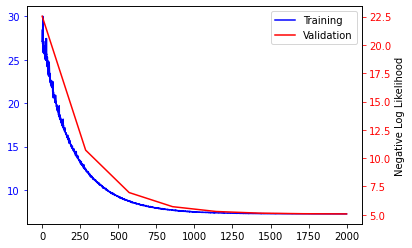

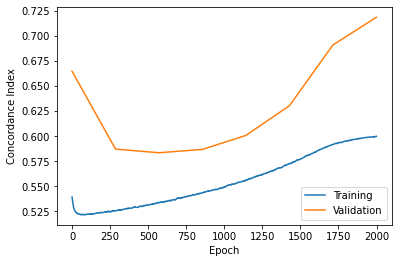

In [35]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

# NN to predict Cox Regression Output

# NN trained on live patients to predict time-to-death 

## Imports

In [36]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from torchvision import utils
from sklearn.metrics import confusion_matrix
import numpy as np 
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

## Load Data

### Define Custom Pytorch Dataset object

In [37]:
# Create PyTorch DNAm dataset from the phenos and DNAm datasets and make the PCs for them to use
class FHSDNAmPCADataset(Dataset):
    """Create FHS DNA methylation data PCs."""

    def __init__(self, PCs, labels, transform=None):
        """
        Args:
            PCs (string): The PCA PCs for the dataset.
            labels (string): the labels for the dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.dataset = PCs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = (self.dataset[idx, :], self.labels[idx])

        if self.transform:
            sample = self.transform(sample)

        return sample

In [38]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        DNA_PCs, death_date = sample
        DNA_PCs = DNA_PCs.astype(float)
        death_date = death_date.astype(float)  
        
        if isinstance(death_date, np.ndarray):
            return (torch.from_numpy(DNA_PCs, torch.from_numpy(death_date.astype(float))))
        else:
            return (torch.from_numpy(DNA_PCs), torch.FloatTensor([death_date]))

### Create Dataset

In [39]:
phenos = pd.read_feather(base_dataf + "phenoFHS.feather" )
dna = pd.read_feather(base_dataf + "FHS_DNAm.feather" )

In [40]:
subset_idxs = (phenos['Lab'] == 2) & (phenos['Cohort'] == "Offspring")
phenos = phenos[subset_idxs]
dna = dna[subset_idxs]

In [41]:
N_COMPONENTS = 500
from sklearn.decomposition import PCA
pca = PCA(n_components=N_COMPONENTS)
dna_transformed = pca.fit_transform(dna)

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
idxs = sss.split(phenos, phenos["Dead"])
train_idxs, test_idxs = next(idxs)

In [43]:
phenos.iloc[train_idxs]["Time"].astype(float).to_numpy().shape
# dna_transformed[train_idxs, :].shape

(1808,)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

train_dataset = FHSDNAmPCADataset(PCs = dna_transformed[train_idxs, :],
                                        labels = phenos.iloc[train_idxs]["Time"].astype(float).to_numpy(),
                                         transform=transforms.Compose([
                                               ToTensor()
                                           ]))

test_dataset = FHSDNAmPCADataset(PCs = dna_transformed[test_idxs, :],
                                        labels = phenos.iloc[test_idxs]["Time"].astype(float).to_numpy(),
                                         transform=transforms.Compose([
                                               ToTensor()
                                           ]))


In [45]:
len(train_dataset)

1808

In [46]:
for i in range(len(train_dataset)):
    data, target = train_dataset[i]
    
    print(data.shape)
    print(i, data.size(), target.size())

    if i == 3:
        break

torch.Size([500])
0 torch.Size([500]) torch.Size([1])
torch.Size([500])
1 torch.Size([500]) torch.Size([1])
torch.Size([500])
2 torch.Size([500]) torch.Size([1])
torch.Size([500])
3 torch.Size([500]) torch.Size([1])


In [47]:
train_loader = DataLoader(train_dataset, batch_size=128,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=False, num_workers=0)

for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break
    
for data, target in test_loader:
    print(data.shape)
    print(target.shape)
    break    

torch.Size([128, 500])
torch.Size([128, 1])
torch.Size([32, 500])
torch.Size([32, 1])


## Create Deep NN

In [48]:
class TimeToDeathNN(nn.Module):
    def __init__(self, ncomponents):
        super(TimeToDeathNN, self).__init__()

        self.fc1 = nn.Linear(ncomponents, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 300)
        self.fc4 = nn.Linear(300, 300)        
        self.fc5 = nn.Linear(300, 1)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc4(x))
        x = self.fc5(x)

        return x


## Train

In [49]:
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
def train(trainloader, criterion, lr, num_epochs, ncomponents=300, regularization=False):
    model = TimeToDeathNN(ncomponents=ncomponents).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.8))
    
    # initialize loss list
    metrics = [[0, 0]]

    # iterate over epochs
    for ep in range(num_epochs):
        model.train()

        # iterate over batches
        for batch_indx, batch in enumerate(trainloader):

            # unpack batch
            data, labels = batch

            # get predictions from model
            pred = model(data.float().to(device))

            loss = criterion(pred.float().cpu(),labels.float().cpu())
                
            if regularization == "l2":
                l2_loss = torch.zeros(1)                
                for name, W in model.named_parameters():                
                    if "bias" not in name:
                        l2_loss += torch.sum(torch.pow(W, 2))
                l2_loss = l2_loss * (reg_lambda / (2*labels.shape[0]))
                loss += l2_loss[0]

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
            
        # compute full train and test accuracies 
        # every epoch
        model.eval() # model will not calculate gradients for this pass
        train_ep_pred = model(data.float().to(device))

        train_mse = mean_squared_error(labels.cpu().detach().numpy(), train_ep_pred.cpu().detach().numpy())
        train_r2 = r2_score(labels.cpu().detach().numpy(), train_ep_pred.cpu().detach().numpy())
        
        # print loss every 100 epochs
        if ep % 10 == 0:
            print("train MSE: {}\t at epoch: {}".format(train_mse, ep))
            print(f"train R^2: {train_r2}")
        metrics.append([train_mse, train_r2])

    return np.array(metrics), model
    
    

In [58]:
def test(model, device, test_loader):

    model.eval()
    test_mse = 0
    test_r2 = 0
    
    # stop tracking gradients
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            output = model(data.float())

            test_mse += mean_squared_error(labels.float().cpu().detach().numpy(), 
                                          output.detach().cpu().numpy())
            test_r2 += r2_score(labels.float().detach().cpu().numpy(), 
                                output.detach().cpu().numpy())
            
            
    test_mse /= len(test_loader.dataset)
    test_r2 /= len(test_loader.dataset)
    
    print('\nTest set: Average MSE Loss: {:.4f}, Average R^2: {}\n'.format(
        test_mse, test_r2))



In [59]:
loss = nn.MSELoss(reduction='mean')
metrics, model = train(train_loader, loss, 0.0001, 300, ncomponents=500)
test(model,device, test_loader)

train MSE: 221013888.0	 at epoch: 0
train R^2: -599.9503068789205
train MSE: 220119808.0	 at epoch: 10
train R^2: -620.8674252027366
train MSE: 176630256.0	 at epoch: 20
train R^2: -789.9648555433253
train MSE: 25167968.0	 at epoch: 30
train R^2: -245.21766206418366
train MSE: 1251647.25	 at epoch: 40
train R^2: -2.882763773978931
train MSE: 348292.90625	 at epoch: 50
train R^2: 0.36074759036503
train MSE: 321065.8125	 at epoch: 60
train R^2: -0.4588019013859701
train MSE: 240270.875	 at epoch: 70
train R^2: 0.1176920296806272
train MSE: 138388.6875	 at epoch: 80
train R^2: -0.3247034204767938
train MSE: 165055.953125	 at epoch: 90
train R^2: 0.1055748859300113
train MSE: 242317.765625	 at epoch: 100
train R^2: 0.672048852565299
train MSE: 91449.484375	 at epoch: 110
train R^2: 0.5920354695688598
train MSE: 60030.19921875	 at epoch: 120
train R^2: 0.7249248188054287
train MSE: 77463.5859375	 at epoch: 130
train R^2: 0.6610470633204725
train MSE: 114819.8125	 at epoch: 140
train R^2: 0.

In [60]:
import matplotlib.pyplot as plt

In [61]:
# np.arange(metrics.shape[0])
# metrics[:,0]

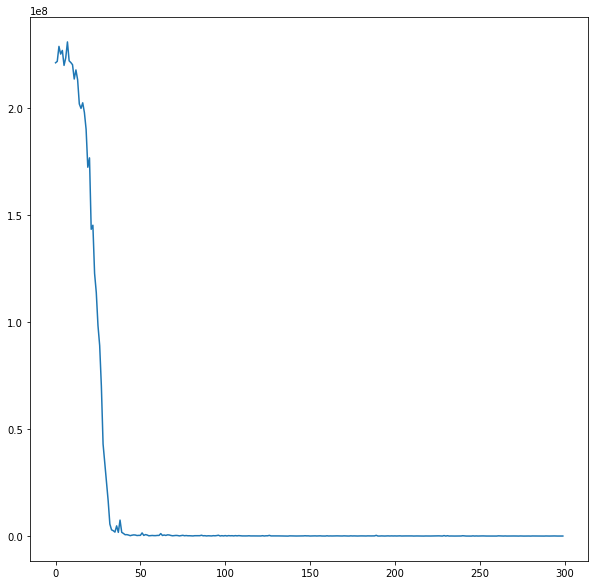

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.arange(metrics.shape[0] - 1), metrics[1:,0])

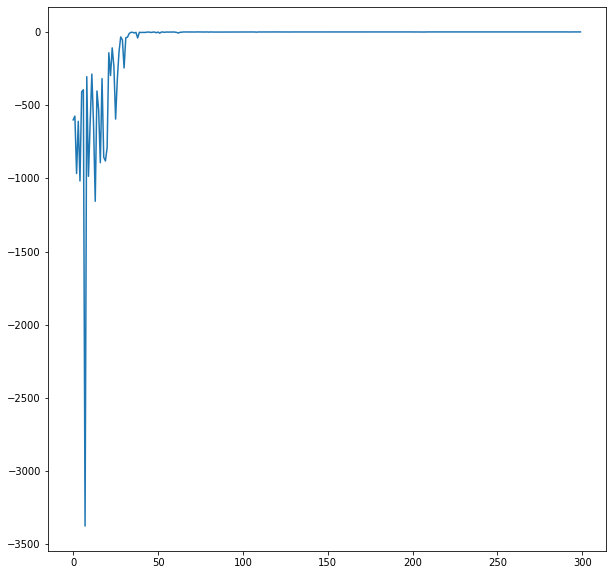

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.arange(metrics.shape[0] - 1), metrics[1:,1])